### Linear Shift-Invariant Image Filtering

Generally, filtering means neiborhood operation. And the term "linear shift-invariant image filtering" means to replace the pixels by a linear combination of their neighbors via a same rule. The rule is determined by the __kernel__ of the filtering. Note that the 

For example, $g[\cdot, \cdot] = \frac{1}{9}\, \begin{bmatrix}1& 1& 1\\ 1& 1& 1\\ 1& 1& 1\end{bmatrix}$ is called the __box filter__.
Then get the output $h[m,n]$ given kernel $g$ and signal $f[m, n]$ by 'convolution'
$$h[m, n] = \sum_{i, j} g[i, j]f[m + j, n + j]$$
It's not the convolution in _'Signals and Systems'_, and the idea is not similar.
Although $h(x) * g(x)$ is actually $g(x) * h(x)$, but here, in cv, we shift the image, not the _response_. It's more like a image to pass across a filter, not a filter processing a image

Another filter commonly used to blur an image is Gaussian Filter. Theoretically, it's 
$$g(\mathbf{x};\mathbf{\mu}, \Sigma) = \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}} e^{-\frac{1}{2} (\mathbf{x} - \mu)^T \Sigma^{-1} (\mathbf{x} - \mu)}$$
In bivariate case, it could be simpler, as
$$ g(x, y) = \frac{1}{2\pi \sigma_x \sigma_y \sqrt{1 - \rho^2}} exp -\frac{1}{2(1 - \rho^2)} \Big(\frac{(x - \mu_x)^2}{\sigma_x^2} +\frac{(y - \mu_y)^2}{\sigma_y^2} - 2\rho\frac{(x - \mu_x)(y - \mu_y)}{\sigma_x\sigma_y} \Big)
$$
However, it need to be applied in a discrete environment. So firstly, we'd like to truncate the kernel, secondly, we need to determine the $\sigma$. a common strategy is to be proportional to image size like 2% of the image diagonal since then it's independent of image resolution. And a reasonable truncate is usually at 2-3$\sigma$, and it's better to give kernel an odd length


In [1]:
import cv2

In [2]:
import numpy as np

In [5]:
from matplotlib import pyplot as plt

<img src="dataset/neonlights.jpg" alt="drawing" style="height:400px;"/>

In [241]:
img = cv2.imread('dataset/neonlights.jpg')

In [242]:
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### 1. Filtering in Single Channel
Let's start with a simple case $\to$ filtering a gray-scale image, which has only one channel. Most of the filterings could be represented as a convolution of input signal and kernel; whereas some others are special.
We use `fitering_gray` to implement normal filterings; For median and bilateral filtering, we will write two functions specifically.

Zero-padding:
`np.pad(imgGray, [paddings], 'constant', constant_values=(0, 0))`

##### Functions

In [254]:
def get_padded_img(size, f, ptype = 'constant'):
    lm = size[0]
    ln = size[1]
    if ptype == 'constant':
        return np.pad(f, [(lm // 2, lm // 2), (ln // 2, ln // 2)], ptype, constant_values=(0, 0))
    elif ptype == 'edge':
        return np.pad(f, [(lm // 2, lm // 2), (ln // 2, ln // 2)], ptype)
    else:
        return

In [257]:
def filtering_gray(kernel, f, ptype='constant'):
    h = np.empty_like(f)
    # we assume the kernel is squared and have an odd length
    lm = kernel.shape[0]
    ln = kernel.shape[1]

    padded = get_padded_img((lm, ln), f, ptype)
    
    for m in range(h.shape[0]):
        for n in range(h.shape[1]):
            h[m][n] = np.sum(np.multiply(kernel, padded[m: m + lm, n: n + ln]))
    return h

In [259]:
def filtering_gray_median(ksize, f, ptype='constant'):
    h = np.empty_like(f)
    # we assume the kernel is squared and have an odd length
    lm = kernel.shape[0]
    ln = kernel.shape[1]

    padded = get_padded_img((lm, ln), f, ptype)

    for m in range(h.shape[0]):
        for n in range(h.shape[1]):
            h[m][n] = np.median(padded[m: m + lm, n: n + ln])
    return h

In [620]:
z = lambda x, y, const, sigmaX, sigmaY, corr: const * np.exp(- 1 / (2 * np.sqrt(1 - corr ** 2)) * ( x ** 2 / sigmaX ** 2 + y ** 2 / sigmaY ** 2 - 2 * corr * x * y / sigmaX / sigmaY))
gauss = lambda x, sigmaX: 1 / np.sqrt(2 * np.pi) / sigmaX * np.exp(- 1 / 2 * x ** 2 / sigmaX ** 2)

In [251]:
def get_gaussian_kernel(k, sigmaX, sigmaY = 0, corr = 0):
    # k should be a tuple
    # it supports a covariance between x and y
    if sigmaY == 0:
        sigmaY = sigmaX
    m = k[0]
    n = k[1]
    y, x = np.ogrid[-m // 2 + 1: m // 2 + 1, - n // 2 + 1: n // 2 + 1]
    const = 1 / (2 * np.pi * sigmaX * sigmaY * np.sqrt(1 - corr ** 2)) 
    g = z(x, y, const, sigmaX, sigmaY, corr)
    #normalize
    return g / np.sum(g)

##### Usage

In [163]:
box_filter = np.ones((7, 7)) / 49
gy, gx = get_separate_gaussian_kernel((5, 5),3)
gm = get_gaussian_kernel((7, 7), 2)

In [256]:
blurred = filtering_gray(gm, imgGray)

In [293]:
#gaussian blur with a covariance
blurred2 = filtering_gray(get_gaussian_kernel((7, 7), 2, 2, 0.5), imgGray)

In [245]:
boxed = filtering_gray(box_filter, imgGray)

In [246]:
medianed = filtering_gray_median((7, 7), imgGray)

It's not easy to get conclusion from thumbnails. So let's output the image to hard disk first and crop the interest region.

In [248]:
cv2.imwrite("dataset/imgGray.jpg", imgGray)
cv2.imwrite("dataset/blurred.jpg", blurred)
cv2.imwrite("dataset/blurred2.jpg", blurred2)
cv2.imwrite("dataset/imgGray.jpg", imgGray)
cv2.imwrite("dataset/medianed.jpg", medianed)
cv2.imwrite("dataset/boxed.jpg", boxed)

True

Left |  Right
 --- | --- 
 Gaussian Blur with $\rho = 1$ with ksize = 7  |Gaussian Blur with $\rho = 0.5$ with ksize = 7 | 
<img src="dataset/blur_crop.jpg" width="350"> |  <img src="dataset/blur2_crop.jpg" width="350"> 
Box filtered with ksize = 7 | Medianed with ksize = 7
<img src="dataset/box_crop.jpg" width="350"> | <img src="dataset/median_crop.png" width="300">

---
#### Acceleration
When the rank of a filter is one, it could be constructed by a outer product of two vectors, which means that it could be splited into two steps and computed separately. This trick is useful for accelerating the process.
For a $M \times M$ image and a $N \times N$ kernel, before splitting, the cost is $N \times N \, \times \, M \times M$. After spliting, it will be $2 \times N \, \times \, M \times M$

In [524]:
def get_separate_gaussian_kernel(k, sigmaX, sigmaY = 0):
    ## here x and y must be independent
    if sigmaY == 0:
        sigmaY = sigmaX
    m = k[0]
    n = k[1]
    y, x = np.ogrid[-m // 2 + 1: m // 2 + 1, - n // 2 + 1: n // 2 + 1]
    y = gauss(y, sigmaY)
    x = gauss(x, sigmaX)
    y /= np.sum(y)
    x /= np.sum(x)
    #normalize
    return y, x

In [554]:
def filtering_gray_separate_kernel(ky, kx, f, ptype='constant'):
    # we assume the kernel is squared and have an odd length
    lm = ky.shape[0]
    ln = kx.shape[1]

    padded = get_padded_img((lm, ln), f, ptype)
    h = np.zeros_like(padded, dtype = float)

    for m in range(h.shape[0] - lm + 1):
        for n in range(ln // 2, h.shape[1] - ln // 2 + 1):
            h[m + lm // 2][n] = np.sum(np.multiply(ky, padded[m: m + lm, n: n + 1]))
            
    for m in range(lm // 2, h.shape[0] - lm // 2 + 1):
        for n in range(h.shape[1] - ln + 1):
            h[m][n + ln // 2] = np.sum(np.multiply(kx, h[m: m + 1, n: n + ln]))
      
    return h[lm // 2 : -lm // 2 + 1, ln // 2 : - ln // 2 + 1].astype(np.uint8)

In [555]:
ky, kx = get_separate_gaussian_kernel((7, 7), 2)
%time blurred3 = filtering_gray_separate_kernel(ky, kx, imgGray)

Wall time: 7.57 s


In [318]:
%time blurred = filtering_gray(gm, imgGray)

Wall time: 5.32 s


In [556]:
np.sum(imgGray - blurred)

61807203

In [557]:
np.sum(imgGray - blurred3)

62901898

It's shown that the result of separate filter and grid filter is almost identical. However, it can't efficiently deduced the running time. I think it's because we the second 'for-loop'; Without parallel computing, the cost of loop is more noticeable.

In [558]:
cv2.imwrite("dataset/blurred3.jpg", blurred3)

True

-------

#### Bilateral

![bilateral filter](dataset/bilateral_filter.jpg)

Gaussian | Bilateral
--- | ---
Edge are blurred | Edge are preserved
Same kernel everywhere. | Kernel shape depends on the image content


__Choice of parameters__ : shoule be independent of resolution and exposure
- space parameter: proportional to image size
  - e.g., 2% of image diagonal
- Range parameter: proportional to edge amplitude
  - e.g., mean or median of image gradients

__Iterating the Bilateral Filter__
- Generate more piecewise-flat images
- Often not needed in computational photo, but could be useful for applications such as NPR.



In [559]:
mountain = cv2.imread('dataset/mountain.jpg')
mountainGray = cv2.cvtColor(mountain, cv2.COLOR_BGR2GRAY)

(-0.5, 959.5, 640.5, -0.5)

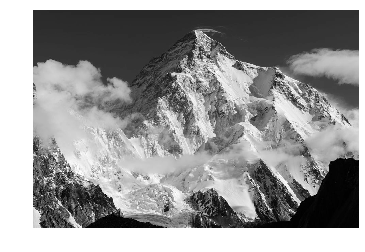

In [562]:
plt.imshow(mountainGray, cmap = 'gray')
plt.axis("off")

In [667]:
def mean_gradient(f):
    sobel = np.array([1, 0, -1])
    gy = filtering_gray(sobel, f)
    gx = filtering_gray(sobel.T, f)
    
    return np.median(np.sqrt(gy ** 2 + gx ** 2))

# when using sobel, the result is 5, which seems to be not noticeable, so I discard the procedure of smooth, try again

In [659]:
def bilateral_filter(f, sigmaS, sigmaR, useMean = True):
    
    h = np.empty_like(f, dtype = float)
    #kernel length
    kl = int(np.sqrt(np.sum(np.power(f.shape, 2))) * 0.02)
    #kl = 3
    gaussS = get_gaussian_kernel((kl, kl), sigmaS)
    gaussR = gauss #(x, sigmaR)
    padded = get_padded_img((kl, kl), f)
    
    for m in range(h.shape[0]):
        for n in range(h.shape[1]):
            #m = 500
            #n = 300
            rang = gaussR(np.abs(padded[m: m + kl, n: n + kl] - padded[m + kl // 2][n + kl // 2]), sigmaR)          
            #print(np.abs(padded[m: m + kl, n: n + kl] - padded[m + kl // 2][n + kl // 2]))

            space = np.multiply(gaussS, rang)
            #print(space)
            space /= np.sum(space)
            #print(space)
            h[m][n] = np.sum(np.multiply(space, padded[m: m + kl, n: n + kl]))
            #print(h[m][n])
            #return
    return h.astype(np.uint8)

In [660]:
%time bilateral_result = bilateral_filter(mountainGray.astype(int), 2, 5, useMean = False)

Wall time: 32 s


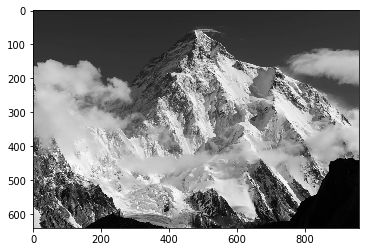

In [661]:
cv2.imwrite('dataset/bilateral_result2.jpg', bilateral_result)
plt.imshow(bilateral_result, cmap = 'gray')

It's shown that the scale of parameter is quite different from what we usually used. So a mean of image gradient may be required.

In [669]:
mean_gradient(mountainGray.astype(int))

(array([[-42, -42, -42, ..., -49, -49, -49],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,  -1, ...,   0,   0,   0],
        [  0,  -4,   0, ...,   0,   0,   0],
        [206, 203, 209, ...,   4,   4,   4]]),
 array([[ -42,    0,    0, ...,    0,    0,   49],
        [ -42,    0,    0, ...,    0,    0,   49],
        [ -42,    0,    0, ...,    0,    0,   49],
        ...,
        [-203,   -2,    3, ...,    0,    0,    4],
        [-203,   -3,    3, ...,    0,    0,    4],
        [-207,   -2,    9, ...,    0,    0,    4]]))

A Fast Approximation of the Bilateral Filter using a Signal Processing Approach

denoising
tone mapping
Photographic Style Transfer

https://www.csie.ntu.edu.tw/~cyy/courses/vfx/10spring/lectures/handouts/lec14_bilateral_4up.pdf